In [25]:
using Flux, Statistics
using Flux.Data: DataLoader
using Flux: onehotbatch, onecold, @epochs
using Flux.Losses: logitcrossentropy
using Base: @kwdef
using CUDA
using MLDatasets
using Plots

In [33]:
ENV["DATADEPS_ALWAYS_ACCEPT"] = "true";

@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = 256    ## batch size
    epochs::Int = 1000      ## number of epochs
    use_cuda::Bool = true   ## use gpu (if cuda available)
end
args = Args();

In [27]:
## Load dataset. Reshape input data to flatten each image into a linear array
xtrain, ytrain = MLDatasets.MNIST(:train)[:];
xtest, ytest = MLDatasets.MNIST(:test)[:];
xtrain = Flux.flatten(Float32.(xtrain .>= 0.5));
xtest = Flux.flatten(Float32.(xtest .>= 0.5));

## One-hot-encode the labels
ytrain, ytest = onehotbatch(ytrain, 0:9), onehotbatch(ytest, 0:9);

## Create two DataLoader objects (mini-batch iterators)
train_loader = DataLoader((xtrain, ytrain), batchsize=args.batchsize, shuffle=true);
test_loader = DataLoader((xtest, ytest), batchsize=args.batchsize);

In [28]:
function build_model(; imgsize=(28,28,1), nclasses=10)
    return Chain( Dense(prod(imgsize), 32, relu),
                  Dense(32, nclasses))
end;

In [29]:
function loss_and_accuracy(data_loader, model, device)
    acc = 0
    ls = 0.0f0
    num = 0
    for (x, y) in data_loader
        x, y = device(x), device(y)
        ŷ = model(x)
        ls += logitcrossentropy(ŷ, y, agg=sum)
        acc += sum(onecold(ŷ) .== onecold(y)) ## Decode the output of the model
        num +=  size(x)[end]
    end
    return ls / num, acc / num
end;

In [34]:
## Train
CUDA.allowscalar(false)
device = gpu

## Construct model
model = build_model() |> device
ps = Flux.params(model) ## model's trainable parameters

## Optimizer
opt = ADAM(args.η)

Ltrain = []
Ltest = []
Atrain = []
Atest = []

## Training
@time for epoch in 1:args.epochs
    for (x, y) in train_loader
        x, y = device(x), device(y) ## transfer data to device
        gs = gradient(() -> logitcrossentropy(model(x), y), ps) ## compute gradient
        Flux.Optimise.update!(opt, ps, gs) ## update parameters
    end

    ## Report on train and test
    train_loss, train_acc = loss_and_accuracy(train_loader, model, device)
    test_loss, test_acc = loss_and_accuracy(test_loader, model, device)
    append!(Ltrain,train_loss)
    append!(Ltest,test_loss)
    append!(Atrain,train_acc)
    append!(Atest,test_acc)
    # println("Epoch=$epoch")
    # println("  train_loss = $train_loss, train_accuracy = $train_acc")
    # println("  test_loss = $test_loss, test_accuracy = $test_acc")
end

425.065450 seconds (580.72 M allocations: 417.209 GiB, 2.77% gc time, 0.04% compilation time)


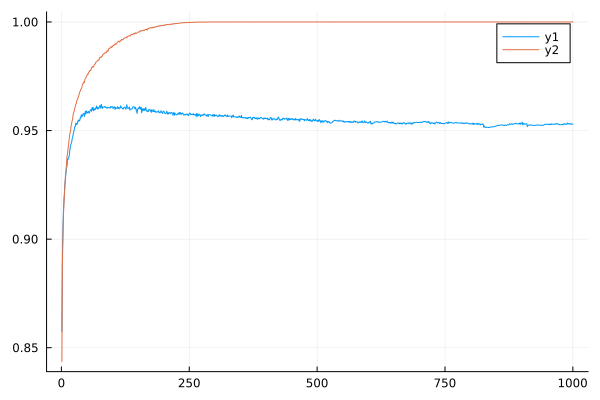

In [35]:
plt = plot(Atest)
plot!(plt,Atrain)

In [36]:
Atest[end],Atrain[end]

(0.953, 1.0)